In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

Using TensorFlow backend.


### Hyperparameters

In [2]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 20
epsilon_std = 1.0

### Encoder

In [3]:
x = Input(batch_shape=(batch_size,original_dim))
h = Dense(intermediate_dim,activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

print(z_mean)
print(z_log_var)

Tensor("dense_2/BiasAdd:0", shape=(100, 2), dtype=float32)
Tensor("dense_3/BiasAdd:0", shape=(100, 2), dtype=float32)


### Sampling

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    
    #Returns a tensor with normal distribution of values.
    #https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal
    epsilon = K.random_normal(shape=(batch_size,latent_dim),mean=0.0)
    
    return z_mean + K.exp(z_log_var / 2) * epsilon

#Wraps arbitrary expression as a Layer object.
#https://keras.io/layers/core/
z = Lambda(sampling, output_shape=(latent_dim,)) ([z_mean,z_log_var])

#latent hidden state
print(z)

Tensor("lambda_1/add:0", shape=(100, 2), dtype=float32)


### Decoder

In [5]:
#creating for the sake of reuse
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')

h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

print(x_decoded_mean)

Tensor("dense_5/Sigmoid:0", shape=(100, 784), dtype=float32)


### Loss

In [6]:
def vae_loss(x, x_decoded_mean):
    
    #https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
    xent_loss = original_dim * objectives.binary_crossentropy(x,x_decoded_mean)
    
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var) , axis = -1)
    
    return xent_loss + kl_loss

### VAE Model

In [7]:
#model = Model(inputs=a, outputs=b)
#This model will include all layers required in the computation of b given a.

vae = Model(x,x_decoded_mean)
vae.compile(optimizer='rmsprop',loss = vae_loss)

### Train VAE on mnist digits

In [8]:
(x_train,y_train) , (x_test,y_test) = mnist.load_data()

x_train = x_train.astype('float32')/255.0
#np.prod Return the product of array elements over a given axis.
x_train = x_train.reshape( (len(x_train) , np.prod(x_train.shape[1:]) ) )

x_test = x_test.astype('float32')/255.0
x_test = x_test.reshape( (len(x_test) , np.prod(x_test.shape[1:]) ) )

vae.fit(x_train,x_train,
        shuffle = True,
        epochs = epochs,
        batch_size = batch_size,
        validation_data = (x_test, x_test),
        verbose=1)


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 9s 154us/step - loss: 188.8643 - val_loss: 171.3406
Epoch 2/20
60000/60000 [==============================] - 6s 108us/step - loss: 169.0295 - val_loss: 167.6758
Epoch 3/20
60000/60000 [==============================] - 7s 112us/step - loss: 165.7869 - val_loss: 165.4009
Epoch 4/20
60000/60000 [==============================] - 8s 125us/step - loss: 163.5705 - val_loss: 162.9825
Epoch 5/20
60000/60000 [==============================] - 8s 127us/step - loss: 161.7513 - val_loss: 161.0993
Epoch 6/20
60000/60000 [==============================] - 7s 116us/step - loss: 160.2459 - val_loss: 159.6879
Epoch 7/20
60000/60000 [==============================] - 8s 128us/step - loss: 159.0511 - val_loss: 158.8185
Epoch 8/20
60000/60000 [==============================] - 10s 164us/step - loss: 158.1775 - val_loss: 158.893858.179
Epoch 9/20
60000/60000 [==============================] - 8s 14

### plot latent/hidden layer

(10000, 2)


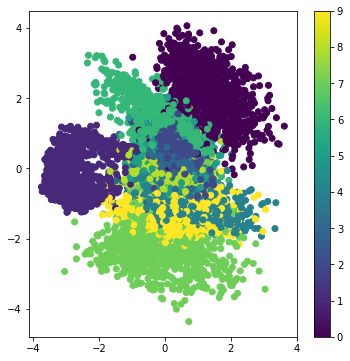

In [9]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
print(x_test_encoded.shape)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

### a digit generator that can sample from the learned distribution

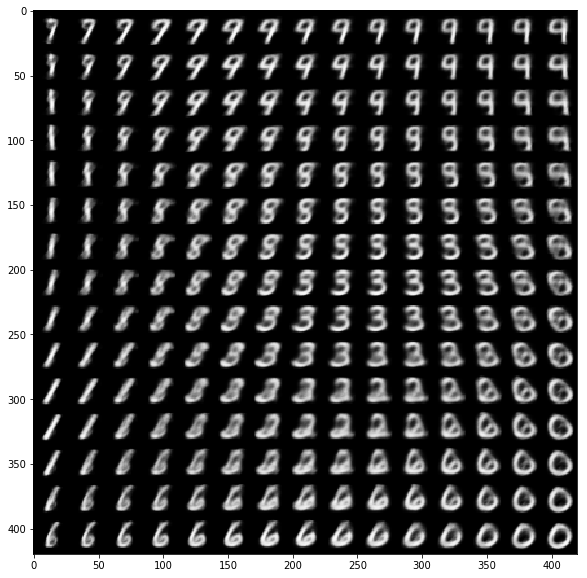

In [10]:
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()